# The Solovay-Kitaev transpiler pass

A QOSF Mentorship program project by Lisa Noorlander (github.com/LNoorl)

**Task:** Approximate continuous single-qubit gates with a discrete basis gate set.

**Reference:** [arXiv:quant-ph/0505030](https://arxiv.org/abs/quant-ph/0505030)

**PR #5657**: https://github.com/Qiskit/qiskit-terra/pull/5657

![discrete gates](discrete-gates.png)

How does it work?

![SK sketch](sk-sketch.png)

## Example: Single qubit gate

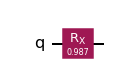

In [1]:
from qiskit.circuit import QuantumCircuit

single_gate = QuantumCircuit(1)
single_gate.rx(0.987, 0)
single_gate.draw(output='mpl', style='iqx')

In [2]:
from qiskit.transpiler.passes import SolovayKitaevDecomposition

basis_gates = ['h', 't', 'tdg']
approximation_depth = 3  # consider all combinations of the basis gates up to length 3

recursion_degree = 2  # how often to improve the initial approximation error

sk = SolovayKitaevDecomposition(recursion_degree, basis_gates, approximation_depth)

Let's run this simple approximation:

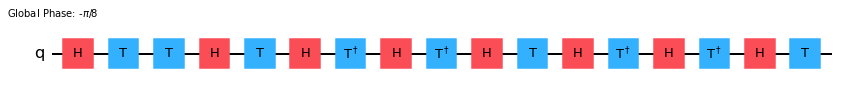

In [3]:
simple_approx = sk(single_gate)
simple_approx.draw(output='mpl', style='iqx')

How well did we approximate?

In [4]:
from qiskit.quantum_info import diamond_norm, Choi

def error(exact, approximation):
    return diamond_norm(Choi(exact) - Choi(approximation))

In [5]:
error(single_gate, simple_approx)

0.2270801967274173

How can we improve the approximation?
* Improve the basic approximations
* Increase the recursion depth (works only if the basic approximations are good!)

### Improving the basic approximations

In [6]:
basis_gates = ['h', 't', 'tdg']
approximation_depth = 10
recursion_degree = 2  

# Takes forever (in Python at least)! 
# sk = SolovayKitaevDecomposition(recursion_degree, basis_gates, approximation_depth)

Generate once and re-use:

In [7]:
fname = 'depth10.npy'
basis_gates = ['h', 't', 'tdg']
approximation_depth = 10

# generate
# SolovayKitaevDecomposition.generate_basic_approximations(basis_gates, approximation_depth, fname)


# load
recursion_degree = 2  
sk = SolovayKitaevDecomposition(recursion_degree)
sk.load_basic_approximations(fname)

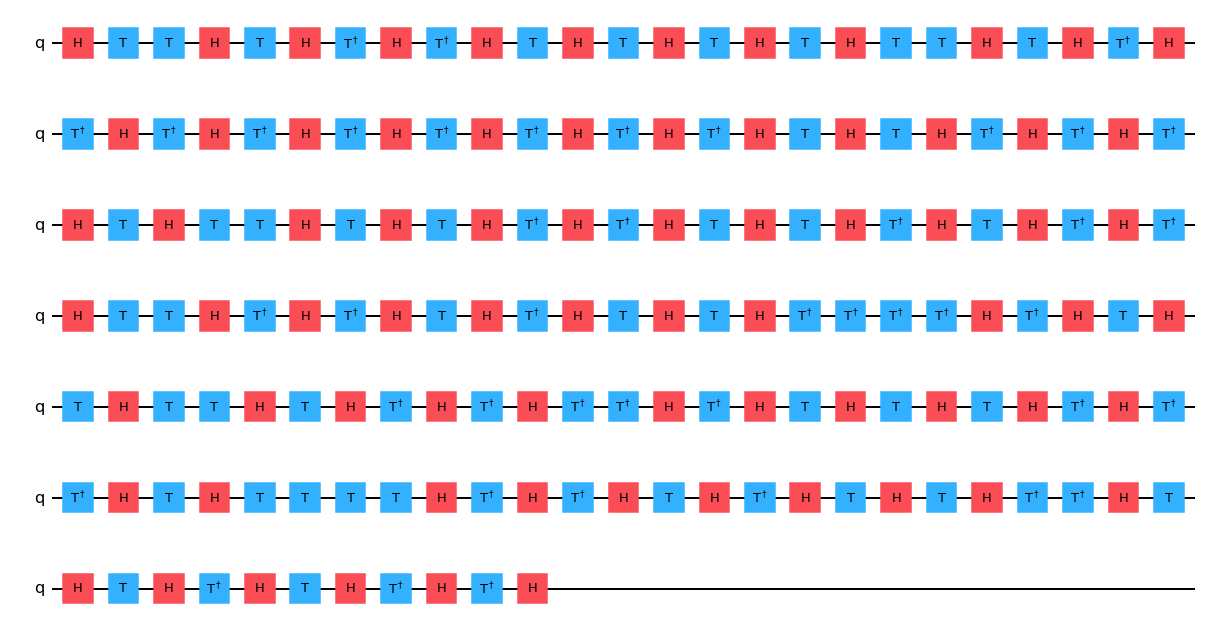

In [8]:
approx = sk(single_gate)
approx.draw(output='mpl', style='iqx')

In [9]:
print('Combinations up to 3 gates and 2 recursions:', error(single_gate, simple_approx))
print('Combinations up to 10 gates and 2 recursions:', error(approx, single_gate))

Combinations up to 3 gates and 2 recursions: 0.2270801967274173
Combinations up to 10 gates and 2 recursions: 0.033171234182653615


### Increasing the recursion depth

In [10]:
# load
recursion_degree = 4
sk = SolovayKitaevDecomposition(recursion_degree)
sk.load_basic_approximations(fname)

better_approx = sk(single_gate)
print('Combinations up to 10 gates and 4 recursions:', error(better_approx, single_gate))
print('Ops:', better_approx.count_ops())

Combinations up to 10 gates and 4 recursions: 0.00019860212062282982
Ops: OrderedDict([('h', 1660), ('t', 975), ('tdg', 974)])


## Example: QFT

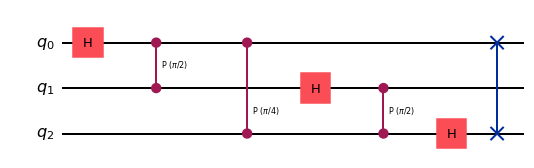

In [11]:
from qiskit.circuit.library import QFT

circuit = QFT(3)
circuit.draw(output='mpl', style='iqx')

Transpiled into single-qubit gates and CX gates it looks like this:

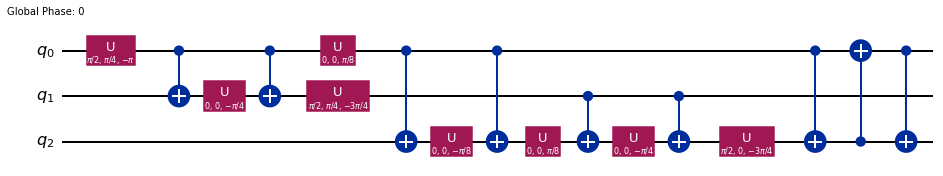

In [12]:
from qiskit import transpile
transpiled = transpile(circuit, basis_gates=['u', 'cx'], optimization_level=1)
transpiled.draw(output='mpl', style='iqx')

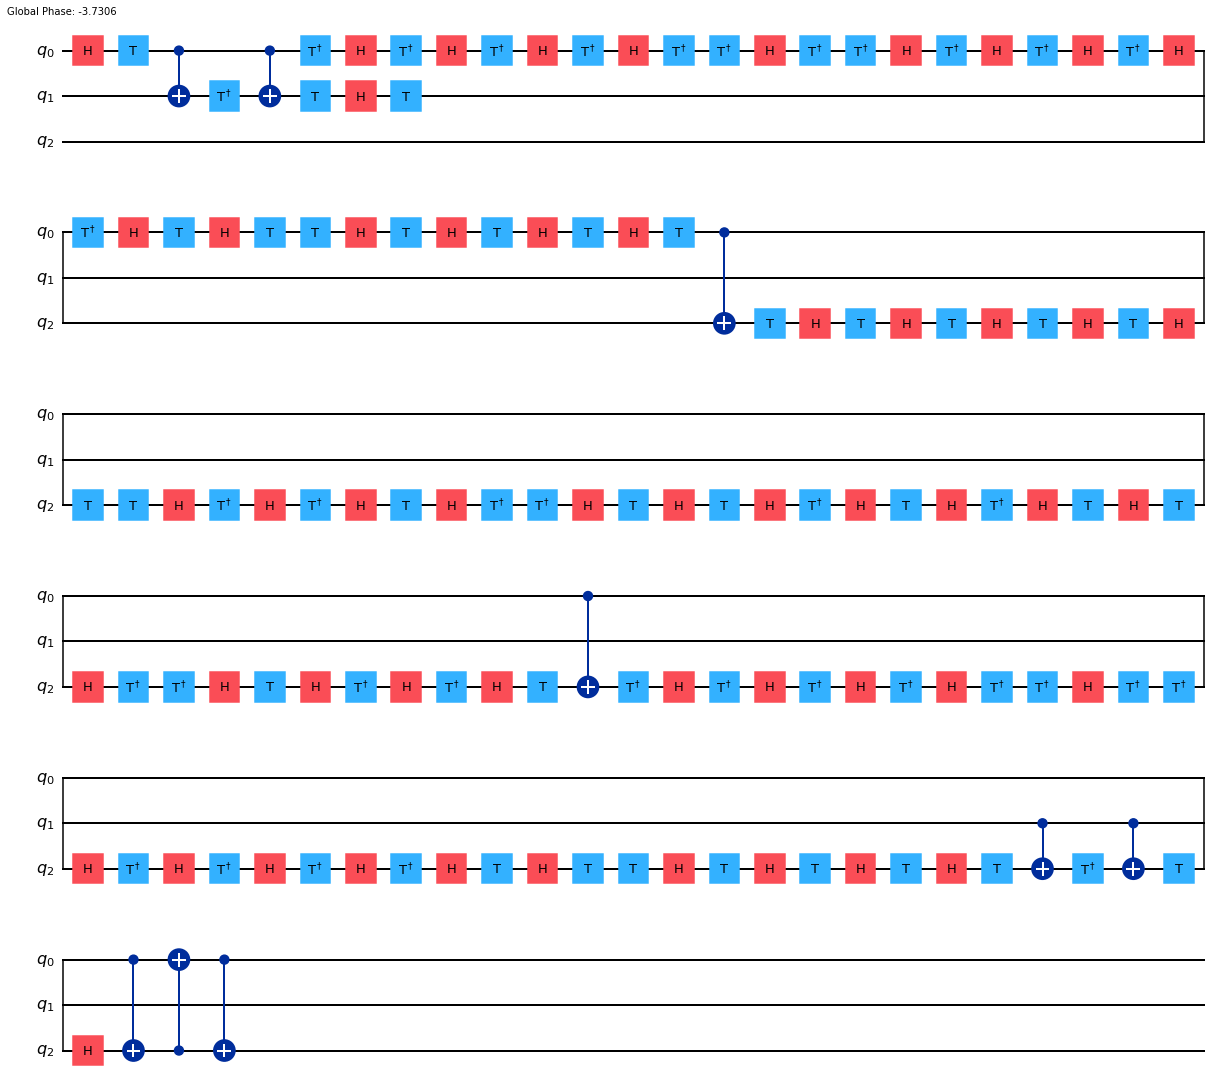

In [13]:
recursion_depth = 1
sk = SolovayKitaevDecomposition(recursion_depth)
sk.load_basic_approximations(fname)

sk(transpiled).draw(output='mpl', style='iqx')

In [14]:
def apply_sk(recursion_depth):
  
    sk = SolovayKitaevDecomposition(recursion_depth)
    sk.load_basic_approximations(fname)
    
    # run SK algorithm
    discretized = sk(transpiled)
    
    return discretized

In [15]:
from time import time
from matplotlib import pyplot as plt

degrees = [1, 2, 3, 4, 5, 6]
errors = []
tcount = []
runtimes = []

for degree in degrees:
    start = time()
    approx = apply_sk(degree)
    runtimes.append(time() - start)
    errors.append(error(circuit, approx))
    gate_counts = approx.count_ops()
    tcount.append(gate_counts.get('t', 0) + gate_counts.get('tdg', 0))
    print(f'Done in {runtimes[-1]} with an error of {errors[-1]}')
        
degrees = degrees[:len(errors)]

Done in 0.18478703498840332 with an error of 0.24601303712756006
Done in 0.4861459732055664 with an error of 0.0876079935365396
Done in 1.632432222366333 with an error of 0.014796577922861678
Done in 5.546483039855957 with an error of 0.006218309404059543
Done in 21.06479787826538 with an error of 0.00010905412953263396
Done in 83.13190412521362 with an error of 9.690444268149414e-07


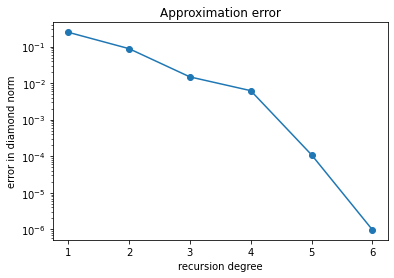

In [16]:
plt.figure()
plt.semilogy(degrees, errors, 'o-')
plt.xlabel('recursion degree')
plt.ylabel('error in diamond norm')
plt.title('Approximation error')
plt.savefig('approxerror.png')

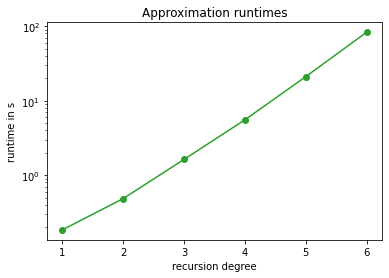

In [17]:
plt.figure()
plt.semilogy(degrees, runtimes, 'o-', color='tab:green')
plt.xlabel('recursion degree')
plt.ylabel('runtime in s')
plt.title('Approximation runtimes')
plt.savefig('approxtime.png')

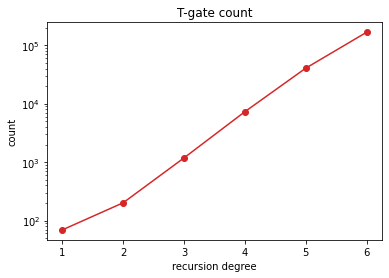

In [18]:
plt.figure()
plt.semilogy(degrees, tcount, 'o-', color='tab:red')
plt.xlabel('recursion degree')
plt.ylabel('count')
plt.title('T-gate count')
plt.savefig('approxtime.png')

## Future work & open questions

* Feed discretized circuit through optimization routine (not working right now!)
* Automatically use Solovay Kitaev if the `basis_gates` in `transpile` are discrete
* Generate larger basis gate approximation sets to download
* Implement the pass in a faster language?